<a href="https://colab.research.google.com/github/rymarinelli/Norbert-Abalation/blob/main/Norbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seb
# ---- FORCE COMPATIBLE STACK FOR LLM2VEC ----
!pip install -y transformers peft accelerate torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.8/304.8 kB 37.6 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Suc


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [6]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.dynamic_module_utils import get_class_from_dynamic_module
from pathlib import Path
import seb
import traceback
import gc

# -----------------------------
# Config
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODELS_TO_EVAL = [
    ("norbert4-xsmall", "ltg/norbert4-xsmall"),
    ("norbert4-small",  "ltg/norbert4-small"),
    ("norbert4-base",   "ltg/norbert4-base"),
    ("norbert4-large",  "ltg/norbert4-large"),
    ("norbert4-xlarge", "ltg/norbert4-xlarge"),
]

POOLING_SETUPS = [
    ("cls",  None, "cls-final"),
    ("mean", None, "mean-final"),
    ("mean", -2,   "mean-llm2vec"),
]

OUT_ROOT = Path("results/norbert4_seb_pooling_ablation")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# -----------------------------
# Encoder
# -----------------------------
class NorBERT4Encoder(seb.Encoder):
    def __init__(self, model_name: str, pooling: str, layer_idx: int | None):
        self.model_name = model_name
        self.pooling = pooling
        self.layer_idx = layer_idx

        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            trust_remote_code=True
        )
        # Ensure pad token is set
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load config first to patch 'is_decoder' if it's missing
        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
        if not hasattr(config, 'is_decoder'):
            # NorBERT is an encoder-only model, so is_decoder should be False
            config.is_decoder = False

        # Dynamically load and patch the model class to fix _init_weights bug
        if hasattr(config, "auto_map") and "AutoModel" in config.auto_map:
            class_ref = config.auto_map["AutoModel"]
            model_class = get_class_from_dynamic_module(class_ref, model_name, trust_remote_code=True)

            # Patch _init_weights to avoid crash on bias-less LayerNorm
            if not getattr(model_class, "_patched_for_bias", False):
                original_init = model_class._init_weights

                def patched_init(self, module):
                    try:
                        original_init(self, module)
                    except AttributeError:
                        # Handle LayerNorm with no bias (module.bias is None)
                        if isinstance(module, torch.nn.LayerNorm) and module.bias is None:
                            # Initialize weight if present (standard init is 1.0)
                            if module.weight is not None:
                                module.weight.data.fill_(1.0)
                        else:
                            raise
                    except Exception:
                         # Fallback for other unexpected init errors
                         pass

                model_class._init_weights = patched_init
                model_class._patched_for_bias = True

            self.model = model_class.from_pretrained(
                model_name,
                config=config,
                output_hidden_states=True,
                trust_remote_code=True,
                torch_dtype=torch.float32,  # Force float32 to avoid instability
            ).to(DEVICE).eval()
        else:
            # Fallback for standard models
            self.model = AutoModel.from_pretrained(
                model_name,
                config=config,
                output_hidden_states=True,
                trust_remote_code=True,
                torch_dtype=torch.float32,
            ).to(DEVICE).eval()

    def mean_pooling(self, token_embeddings, attention_mask):
        """Standard Mean Pooling (like sentence-transformers / LLM2Vec)."""
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def encode(self, sentences, batch_size=32, **kwargs):
        # Reduce batch size to prevent OOM on larger models
        if "xlarge" in self.model_name:
             safe_batch_size = 1 # Extreme caution for xlarge
        elif "large" in self.model_name:
             safe_batch_size = 2
        else:
             safe_batch_size = min(batch_size, 16)

        all_embeddings = []

        for i in range(0, len(sentences), safe_batch_size):
            batch = sentences[i:i + safe_batch_size]

            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(DEVICE)

            # FIX: Convert attention_mask to bool to support custom model logic
            # This prevents ~mask from producing negative integers (-1, -2)
            if "attention_mask" in inputs:
                inputs["attention_mask"] = inputs["attention_mask"].bool()

            with torch.no_grad():
                # Explicitly pass output_hidden_states=True to ensure it's returned
                outputs = self.model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True
                )

                # Select layer
                if self.layer_idx is None:
                    # Usually last_hidden_state has the final norm if applicable
                    h = outputs.last_hidden_state
                else:
                    # hidden_states is a tuple. -1 is last layer. -2 is second to last.
                    if outputs.hidden_states is None:
                         raise ValueError("Model did not return hidden_states. Check model config.")
                    h = outputs.hidden_states[self.layer_idx]

                # Safety check for NaNs in raw output
                if torch.isnan(h).any():
                     print(f"Warning: NaN detected in raw output for {self.model_name}")
                     # If we still get NaNs despite the bool fix, we must handle it to avoid crash
                     h = torch.nan_to_num(h, nan=0.0)

                # Pooling
                # Re-cast mask to float for pooling math
                mask_float = inputs["attention_mask"].float()

                if self.pooling == "cls":
                    emb = h[:, 0]
                elif self.pooling == "mean":
                    emb = self.mean_pooling(h, mask_float)
                else:
                    raise ValueError(f"Unknown pooling: {self.pooling}")

                # Normalize (critical for SEB)
                emb = F.normalize(emb, p=2, dim=1)

                # Final check for NaNs
                if torch.isnan(emb).any():
                    print(f"Warning: NaN detected in final embedding for {self.model_name}")
                    emb = torch.nan_to_num(emb, nan=0.0)

            all_embeddings.append(emb.cpu())

        return torch.cat(all_embeddings, dim=0).numpy()

# -----------------------------
# Run SEB
# -----------------------------
benchmark = seb.Benchmark(
    tasks=[
        "NoReC",
        "Norwegian parliament",
        "Norwegian courts",
        "VG Clustering",
        "TV2Nord Retrieval",
        "NorQuad",
    ]
)

print(f"Loaded {len(benchmark.tasks)} tasks: {[t.name for t in benchmark.tasks]}")

for model_tag, model_name in MODELS_TO_EVAL:
    # Force cleanup before starting a new model architecture
    gc.collect()
    torch.cuda.empty_cache()

    for pooling, layer_idx, pooling_tag in POOLING_SETUPS:

        run_name = f"{model_tag}-{pooling_tag}"
        out_dir = OUT_ROOT / run_name
        out_dir.mkdir(parents=True, exist_ok=True)

        # Check if run already exists to save time (optional, but good for retries)
        # if list(out_dir.glob("*.json")):
        #    print(f"Skipping {run_name}, results exist.")
        #    continue

        print(f"\n=== Running SEB: {run_name} ===")

        # 1. Initialize Encoder
        encoder = None
        seb_model = None
        try:
            encoder = NorBERT4Encoder(
                model_name=model_name,
                pooling=pooling,
                layer_idx=layer_idx,
            )
        except Exception as e:
            print(f"Failed to load model {model_name}: {e}")
            traceback.print_exc()
            continue

        # 2. Wrap in SebModel (requires metadata)
        meta = seb.ModelMeta(
            name=run_name,
            huggingface_name=model_name,
            reference=f"https://huggingface.co/{model_name}",
            # Use 'nb' (Bokmål) to satisfy pydantic validation
            languages=["nb"],
        )
        seb_model = seb.SebModel(encoder=encoder, meta=meta)

        # 3. Evaluate
        try:
            results = benchmark.evaluate_models([seb_model])

            if not results:
                print(f"Warning: No results returned for {run_name}")

            # 4. Save Results
            for model_result in results:
                for task_result in model_result.task_results:
                    # Save as JSON
                    fname = task_result.task_name.replace(" ", "_") + ".json"
                    path = out_dir / fname
                    task_result.to_disk(path)
                    print(f"Saved: {path}")

        except Exception as e:
            print(f"Error evaluating {run_name}: {e}")
            traceback.print_exc()

        # Cleanup memory after each run
        del encoder
        del seb_model
        gc.collect()
        torch.cuda.empty_cache()

print("\nAll SEB runs completed.")

Loaded 6 tasks: ['NoReC', 'Norwegian parliament', 'Norwegian courts', 'VG Clustering', 'TV2Nord Retrieval', 'NorQuad']

=== Running SEB: norbert4-xsmall-cls-final ===


Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xsmall
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xsmall-cls-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-cls-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-cls-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xsmall-cls-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xsmall-cls-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-cls-f

Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-cls-final/NorQuad.json

=== Running SEB: norbert4-xsmall-mean-final ===


Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xsmall
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xsmall-mean-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-mean-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-mean-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xsmall-mean-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xsmall-mean-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-

Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-final/NorQuad.json

=== Running SEB: norbert4-xsmall-mean-llm2vec ===


Loading weights:   0%|          | 0/258 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xsmall
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xsmall-mean-llm2vec on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-mean-llm2vec on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xsmall-mean-llm2vec on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xsmall-mean-llm2vec on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xsmall-mean-llm2vec on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norber

Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xsmall-mean-llm2vec/NorQuad.json

=== Running SEB: norbert4-small-cls-final ===


Loading weights:   0%|          | 0/322 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-small
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-small-cls-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-cls-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-cls-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-small-cls-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-small-cls-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-cls-final: 1

Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-cls-final/NorQuad.json

=== Running SEB: norbert4-small-mean-final ===


Loading weights:   0%|          | 0/322 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-small
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-small-mean-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-mean-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-mean-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-small-mean-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-small-mean-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-mean-fi

Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-final/NorQuad.json

=== Running SEB: norbert4-small-mean-llm2vec ===


Loading weights:   0%|          | 0/322 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-small
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-small-mean-llm2vec on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-mean-llm2vec on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-small-mean-llm2vec on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-small-mean-llm2vec on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-small-mean-llm2vec on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-sma

Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-small-mean-llm2vec/NorQuad.json

=== Running SEB: norbert4-base-cls-final ===


Loading weights:   0%|          | 0/386 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-base-cls-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-cls-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-cls-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-base-cls-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-base-cls-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-cls-final: 100%|███

Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-cls-final/NorQuad.json

=== Running SEB: norbert4-base-mean-final ===


Loading weights:   0%|          | 0/386 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-base-mean-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-base-mean-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-base-mean-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean-final: 10

Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-final/NorQuad.json

=== Running SEB: norbert4-base-mean-llm2vec ===


Loading weights:   0%|          | 0/386 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-base-mean-llm2vec on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean-llm2vec on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean-llm2vec on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-base-mean-llm2vec on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-base-mean-llm2vec on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-base-mean

Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-base-mean-llm2vec/NorQuad.json

=== Running SEB: norbert4-large-cls-final ===


Loading weights:   0%|          | 0/450 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-large
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-large-cls-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-cls-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-cls-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-large-cls-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-large-cls-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-cls-final: 1

Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-cls-final/NorQuad.json

=== Running SEB: norbert4-large-mean-final ===


Loading weights:   0%|          | 0/450 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-large
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-large-mean-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-mean-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-mean-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-large-mean-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-large-mean-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-mean-fi

Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-final/NorQuad.json

=== Running SEB: norbert4-large-mean-llm2vec ===


Loading weights:   0%|          | 0/450 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-large
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-large-mean-llm2vec on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-mean-llm2vec on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-large-mean-llm2vec on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-large-mean-llm2vec on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-large-mean-llm2vec on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-lar

Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-large-mean-llm2vec/NorQuad.json

=== Running SEB: norbert4-xlarge-cls-final ===


Loading weights:   0%|          | 0/514 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xlarge
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xlarge-cls-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-cls-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-cls-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xlarge-cls-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xlarge-cls-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-cls-f

Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-cls-final/NorQuad.json

=== Running SEB: norbert4-xlarge-mean-final ===


Loading weights:   0%|          | 0/514 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xlarge
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xlarge-mean-final on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-mean-final on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-mean-final on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xlarge-mean-final on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xlarge-mean-final on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-

Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-final/NorQuad.json

=== Running SEB: norbert4-xlarge-mean-llm2vec ===


Loading weights:   0%|          | 0/514 [00:00<?, ?it/s]

GptBertModel LOAD REPORT from: ltg/norbert4-xlarge
Key                          | Status     |  | 
-----------------------------+------------+--+-
classifier.projection.scale  | UNEXPECTED |  | 
classifier.emb2vocab.scale   | UNEXPECTED |  | 
classifier.emb2vocab.bias    | UNEXPECTED |  | 
classifier.projection.weight | UNEXPECTED |  | 
classifier.emb2vocab.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Running norbert4-xlarge-mean-llm2vec on NoReC:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-mean-llm2vec on Norwegian parliament:   0%|          | 0/6 [00:00<?, ?it/s]
Running norbert4-xlarge-mean-llm2vec on Norwegian courts:   0%|          | 0/6 [00:00<?, ?it/s]    
Running norbert4-xlarge-mean-llm2vec on VG Clustering:   0%|          | 0/6 [00:00<?, ?it/s]   
Running norbert4-xlarge-mean-llm2vec on TV2Nord Retrieval:   0%|          | 0/6 [00:00<?, ?it/s]
Running norber

Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/NoReC.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/Norwegian_parliament.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/Norwegian_courts.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/VG_Clustering.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/TV2Nord_Retrieval.json
Saved: results/norbert4_seb_pooling_ablation/norbert4-xlarge-mean-llm2vec/NorQuad.json

All SEB runs completed.


Scanning /content/results/norbert4_seb_pooling_ablation...
Found 90 JSON files.

=== Average SEB Scores by Architecture & Pooling ===


Pooling,CLS (Final),Mean (Final),Mean (LLM2Vec)
Architecture,,,
norbert4-xsmall,0.243726,0.243726,0.243726
norbert4-small,0.134778,0.134778,0.134778
norbert4-base,0.134778,0.134778,0.134778
norbert4-large,0.134778,0.134778,0.134778
norbert4-xlarge,0.134778,0.134778,0.134778



=== Detailed Task Scores ===


Architecture         norbert4-base                             norbert4-large  \
Pooling                CLS (Final) Mean (Final) Mean (LLM2Vec)    CLS (Final)   
Task                                                                            
NoReC                     0.163574     0.163574       0.163574       0.163574   
NorQuad                   0.003710     0.003710       0.003710       0.003710   
Norwegian courts          0.004386     0.004386       0.004386       0.004386   
Norwegian parliament      0.500000     0.500000       0.500000       0.500000   
TV2Nord Retrieval         0.002220     0.002220       0.002220       0.002220   

Architecture                                     norbert4-small               \
Pooling              Mean (Final) Mean (LLM2Vec)    CLS (Final) Mean (Final)   
Task                                                                           
NoReC                    0.163574       0.163574       0.163574     0.163574   
NorQuad                  0.003710       0.003710       0.003710     0.003710   
Norwegian courts         0.004386       0.004386       0.004386     0.004386   
Norwegian parliament     0.500000       0.500000       0.500000     0.500000   
TV2Nord Retrieval        0.002220       0.002220       0.002220     0.002220   

Architecture                        norbert4-xlarge               \
Pooling              Mean (LLM2Vec)     CLS (Final) Mean (Final)   
Task                                                               
NoReC                      0.163574        0.163574     0.163574   
NorQuad                    0.003710        0.003710     0.003710   
Norwegian courts           0.004386        0.004386     0.004386   
Norwegian parliament       0.500000        0.500000     0.500000   
TV2Nord Retrieval          0.002220        0.002220     0.002220   

Architecture                        norbert4-xsmall               \
Pooling              Mean (LLM2Vec)     CLS (Final) Mean (Final)   
Task                                                               
NoReC                      0.163574        0.353174     0.353174   
NorQuad                    0.003710        0.004650     0.004650   
Norwegian courts           0.004386        0.324561     0.324561   
Norwegian parliament       0.500000        0.518583     0.518583   
TV2Nord Retrieval          0.002220        0.017660     0.017660   

Architecture                         
Pooling              Mean (LLM2Vec)  
Task                                 
NoReC                      0.353174  
NorQuad                    0.004650  
Norwegian courts           0.324561  
Norwegian parliament       0.518583  
TV2Nord Retrieval          0.017660


CSV saved to /content/results/norbert4_seb_pooling_ablation/_summary/results_summary.csv


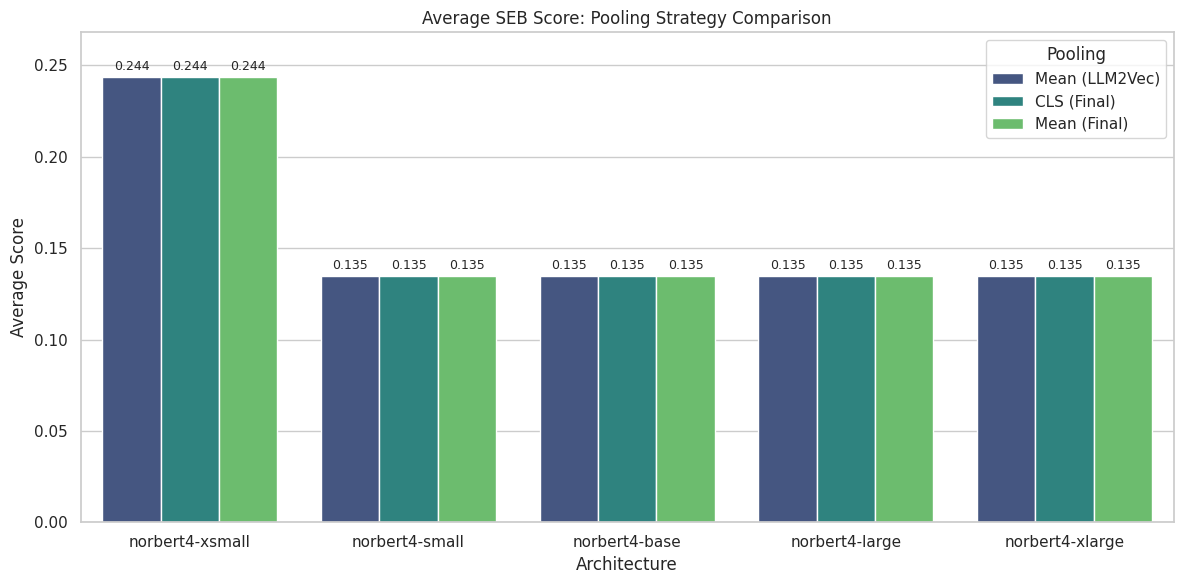

In [7]:
# ======================================================
# Summarize SEB JSON results (Pooling Comparison)
# ======================================================

import json
import os
from pathlib import Path
from typing import Any, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
# Use resolve() to get absolute path
ROOT = Path("results/norbert4_seb_pooling_ablation").resolve()
OUT = ROOT / "_summary"
OUT.mkdir(parents=True, exist_ok=True)

def _first_numeric(x: Any) -> Optional[float]:
    if isinstance(x, (int, float)) and np.isfinite(x):
        return float(x)
    return None

def extract_main_score(d: Dict[str, Any]) -> Tuple[Optional[float], str]:
    """Extract the main score from SEB result JSON."""
    if "main_score" in d:
        v = _first_numeric(d["main_score"])
        if v is not None:
            return v, "main_score"

    if "scores" in d:
        s = d["scores"]
        if isinstance(s, dict):
            # Look for specific metrics inside language keys if present
            for key, val in s.items():
                if isinstance(val, dict):
                    for metric in ["ndcg_at_10", "ndcg", "mrr", "accuracy", "f1", "spearman", "cos_sim"]:
                        if metric in val:
                            v = _first_numeric(val[metric])
                            if v is not None:
                                return v, f"scores.{key}.{metric}"

            # Fallback to direct metrics in 'scores'
            for metric in ["ndcg_at_10", "ndcg", "mrr", "accuracy", "f1", "spearman", "cos_sim"]:
                if metric in s:
                    v = _first_numeric(s[metric])
                    if v is not None:
                        return v, f"scores.{metric}"

    return None, "unknown"

def load_results() -> pd.DataFrame:
    rows = []
    if not ROOT.exists():
        print(f"Error: Path {ROOT} does not exist.")
        print(f"Current working directory: {Path.cwd()}")
        return pd.DataFrame()

    # Search recursively for JSONs
    files = list(ROOT.rglob("*.json"))
    print(f"Scanning {ROOT}...")

    if not files:
        print(f"No JSON files found in {ROOT}.")
        print("Checking immediate subdirectories:")
        try:
            for child in ROOT.iterdir():
                if child.is_dir():
                    print(f" - {child.name} (Contains {len(list(child.glob('*.json')))} json files)")
                else:
                    print(f" - {child.name}")
        except Exception as e:
            print(f"Error listing directory: {e}")
        return pd.DataFrame()

    print(f"Found {len(files)} JSON files.")

    for p in files:
        if "_summary" in p.parts:
            continue

        try:
            data = json.loads(p.read_text(encoding="utf-8"))
        except Exception as e:
            print(f"Error reading {p}: {e}")
            continue

        # Infer model info from directory name
        dir_name = p.parent.name

        if "mean-llm2vec" in dir_name:
             pooling = "Mean (LLM2Vec)"
             arch = dir_name.replace("-mean-llm2vec", "")
        elif "mean-final" in dir_name:
             pooling = "Mean (Final)"
             arch = dir_name.replace("-mean-final", "")
        elif "cls-final" in dir_name:
             pooling = "CLS (Final)"
             arch = dir_name.replace("-cls-final", "")
        else:
             pooling = "Other"
             arch = dir_name

        task_name = p.stem.replace("_", " ")
        score, metric = extract_main_score(data)

        if score is not None:
            rows.append({
                "Model": dir_name,
                "Architecture": arch,
                "Pooling": pooling,
                "Task": task_name,
                "Score": score,
                "Metric": metric
            })

    return pd.DataFrame(rows)

def plot_results(df: pd.DataFrame):
    if df.empty:
        print("No data to plot.")
        return

    # Set plot style
    sns.set_theme(style="whitegrid")

    # 1. Aggregated Pooling Comparison (Bar Chart)
    avg_df = df.groupby(["Architecture", "Pooling"])["Score"].mean().reset_index()

    # Sort architectures by size
    order_map = {
        "norbert4-xsmall": 0,
        "norbert4-small": 1,
        "norbert4-base": 2,
        "norbert4-large": 3,
        "norbert4-xlarge": 4
    }
    avg_df["Order"] = avg_df["Architecture"].map(order_map).fillna(99)
    avg_df = avg_df.sort_values("Order")

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=avg_df,
        x="Architecture",
        y="Score",
        hue="Pooling",
        palette="viridis"
    )
    plt.title("Average SEB Score: Pooling Strategy Comparison")
    plt.ylabel("Average Score")
    plt.xticks(rotation=0)

    # Dynamic Y-limit
    if not avg_df.empty:
        plt.ylim(0, avg_df["Score"].max() * 1.1)

    # Add labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

    plt.tight_layout()
    plt.savefig(OUT / "pooling_comparison_summary.png", dpi=300)
    plt.show()

# --- Execution ---
df = load_results()

if not df.empty:
    # Display Pivot Table (Architecture vs Pooling)
    pivot_df = df.pivot_table(index="Architecture", columns="Pooling", values="Score", aggfunc="mean")

    # Sort index
    order_map = {
        "norbert4-xsmall": 0,
        "norbert4-small": 1,
        "norbert4-base": 2,
        "norbert4-large": 3,
        "norbert4-xlarge": 4
    }
    pivot_df["Order"] = pivot_df.index.map(order_map).fillna(99)
    pivot_df = pivot_df.sort_values("Order").drop(columns="Order")

    print("\n=== Average SEB Scores by Architecture & Pooling ===")
    display(pivot_df) # Use pandas display

    # Detailed Task Breakdown
    print("\n=== Detailed Task Scores ===")
    detailed_pivot = df.pivot_table(index="Task", columns=["Architecture", "Pooling"], values="Score")
    display(detailed_pivot)

    # Save CSV
    csv_path = OUT / "results_summary.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to {csv_path}")

    # Plot
    plot_results(df)
else:
    print("No results loaded.")